In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 as cv
from tqdm import tqdm
from scipy.optimize import curve_fit

# Single mode fibre analysis

In [2]:
# load single mode data images stored in Images/SingleMode

single_mode_image = cv.imread('Images/SingleMode/HP_1.jpg')
# convert to RGB from BGR
single_mode_image = cv.cvtColor(single_mode_image, cv.COLOR_BGR2RGB)

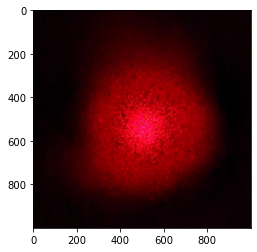

In [3]:
# crop the image to remove edges and get the central part

single_mode_image_crop = single_mode_image[1800:2800, 900:1900]
# display RGB cropped image
plt.imshow(single_mode_image_crop)

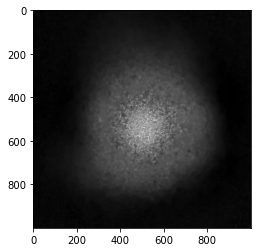

In [4]:
# Convert to grayscale for analysis
single_mode_image_gray = cv.cvtColor(single_mode_image_crop, cv.COLOR_RGB2GRAY)
# display grayscale image
plt.imshow(single_mode_image_gray, cmap='gray')

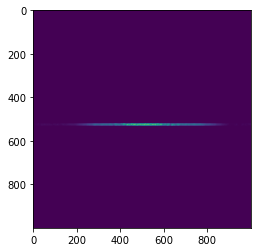

In [5]:
# now analyse the image to get intesity profile across a thin rectangular region

# define a mask to select the region of interest
mask = np.zeros_like(single_mode_image_gray)
mask[520:530, :] = 255

# apply the mask to the image
masked_image = cv.bitwise_and(single_mode_image_gray, mask)

# display the masked image
plt.imshow(masked_image)

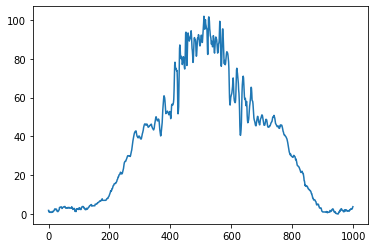

In [6]:
# now get the intensity profile across the region of interest
intensity_profile = single_mode_image_gray[520:530, :].mean(axis=0)

# plot the intensity profile
plt.plot(intensity_profile)

In [7]:
np.shape(single_mode_image_crop)

(1000, 1000, 3)

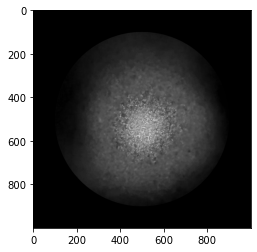

In [8]:
# create a circular mask 
mask = np.zeros_like(single_mode_image_gray)
cv.circle(mask, (int(single_mode_image_gray.shape[1]/2), int(single_mode_image_gray.shape[0]/2)), 400, 255, -1)

# apply the mask to the image
masked_image = cv.bitwise_and(single_mode_image_gray, mask)

# display the masked image
plt.imshow(masked_image, cmap='gray')

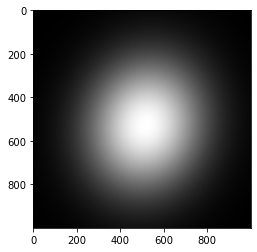

In [9]:
# import astopy 2D gaussian function
from astropy.modeling.functional_models import Gaussian2D
from astropy.modeling import models, fitting

# define a 2D gaussian function
# f_gauss = Gaussian2D(amplitude=np.max(single_mode_image_gray), x_mean=600, y_mean=500, x_stddev=100, y_stddev=100)
f_gauss = Gaussian2D()

# create a grid of x and y values
x = np.arange(0, single_mode_image_gray.shape[1], 1)
y = np.arange(0, single_mode_image_gray.shape[0], 1)
x, y = np.meshgrid(x, y)

# create a 2D gaussian image
gauss_image = f_gauss(x, y)
fit = fitting.LevMarLSQFitter()

# fit the 2D gaussian to the image
fitted_gauss = fit(f_gauss, x, y, single_mode_image_gray)

# display the fitted 2D gaussian
plt.imshow(fitted_gauss(x, y), cmap='gray')

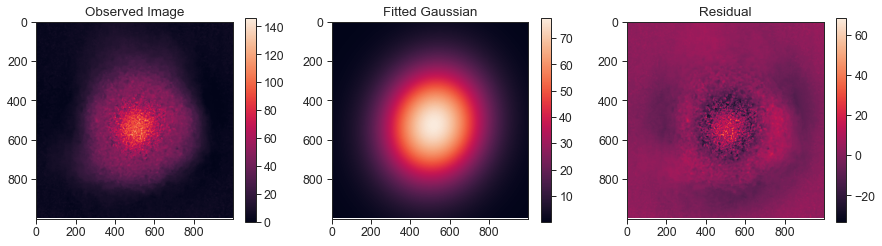

In [10]:
# create 3 supplots showing the original image, the fitted gaussian and the residual
# also disply the colorbar on each subplot
sns.set_style('ticks')
sns.set_context('paper', rc={'lines.linewidth': 1.5}, font_scale=1.4)


fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(single_mode_image_gray)
ax[0].set_title('Observed Image')
# display the colorbar
fig.colorbar(ax[0].imshow(single_mode_image_gray), ax=ax[0], shrink=0.75)

ax[1].imshow(fitted_gauss(x, y))
ax[1].set_title('Fitted Gaussian')
fig.colorbar(ax[1].imshow(fitted_gauss(x, y)), ax=ax[1], shrink=0.75)

ax[2].imshow(single_mode_image_gray - fitted_gauss(x, y))
ax[2].set_title('Residual')
fig.colorbar(ax[2].imshow(single_mode_image_gray - fitted_gauss(x, y)), ax=ax[2], shrink=0.75)

plt.savefig('SingleModeImage.pdf', bbox_inches='tight', dpi=400)

In [11]:
def gaussian(x, a, b, c, d):
    return a * np.exp(-((x - b)**2) / (2 * c**2)) + d


# define a function which rotates the image and fits a gaussian profile.
def profile(image, theta):
    # get the rotation matrix
    M = cv.getRotationMatrix2D((image.shape[1]/2, image.shape[0]/2), theta, scale=1)
    #rotate the image
    rotated_image = cv.warpAffine(image, M, (image.shape[1], image.shape[0]))

    #select a narrow horizontal region and calulate the mean intensity
    intensity_profile = rotated_image[int(image.shape[0]/2-10):int(image.shape[0]/2 + 10), :].mean(axis=0)

    ## fit a gaussian to the intensity profile
    # initial guess of parameters
    p0 = [np.max(intensity_profile), 600, 100, 0]
    # fit
    popt, pconv = curve_fit(gaussian, np.arange(0, len(intensity_profile), 1), intensity_profile, p0=p0)
    # print(popt)

    # return the fitted parameters and the intensity profile
    return popt, pconv, intensity_profile

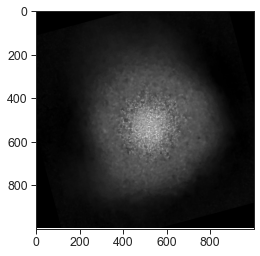

In [12]:
# rotate the image by an angle of 15 degrees
M = cv.getRotationMatrix2D((single_mode_image_gray.shape[1]/2, single_mode_image_gray.shape[0]/2), 15, 1)
rotated_image = cv.warpAffine(single_mode_image_gray, M, (single_mode_image_gray.shape[1], single_mode_image_gray.shape[0]))

# display the rotated image
plt.imshow(rotated_image, cmap='gray')

In [13]:
# keep rotating the image by 18degrees untill you get full 360 degree rotations

Theta = np.linspace(0, 360, 20)
popt_master = []
pconv_master = []
intensity_master = []
for theta in tqdm(Theta, desc='Fitting Gaussian Profiles'):
    popt, pconv, intensity = profile(single_mode_image_gray, theta)
    popt_master.append(popt)
    pconv_master.append(pconv)
    intensity_master.append(intensity)

Fitting Gaussian Profiles: 100%|██████████| 20/20 [00:00<00:00, 213.30it/s]


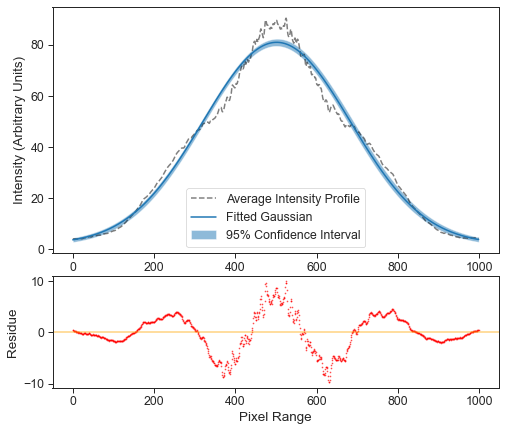

In [14]:
# setting seaborn style
sns.set_style('ticks')
sns.set_context('paper', rc={'lines.linewidth': 1.5}, font_scale=1.4)
from matplotlib.gridspec import GridSpec

x = np.arange(0, len(intensity_master[0]), 1)

# Calculate the average intestity from the observed profiles
intensity_master = np.array(intensity_master)
intensity_mean = intensity_master.mean(axis=0)

# fit a gaussian to the intensity profile
# initial guess of parameters
p0 = [np.max(intensity_mean), 600, 100, 0]
# fit
popt, pconv = curve_fit(gaussian, np.arange(0, len(intensity_mean), 1), intensity_mean, p0=p0)
#get 95% confidence interval
perr = np.sqrt(np.diag(pconv))

#get the upper and lower bounds with 95% confidence interval
upper_bound = gaussian(np.arange(0, len(intensity_mean), 1), *(popt + 1.96*perr))
lower_bound = gaussian(np.arange(0, len(intensity_mean), 1), *(popt - 1.96*perr))

fig = plt.figure(figsize=(8,7))
gs = GridSpec(3,1, figure=fig)
ax1 = fig.add_subplot(gs[0:2, 0])
ax2 = fig.add_subplot(gs[2, 0])

ax1.plot(intensity_mean, label='Average Intensity Profile', color='k', alpha=0.5, ls='--')
ax1.plot(gaussian(np.arange(0, len(intensity_mean), 1), *popt), label='Fitted Gaussian')
ax1.fill_between(np.arange(0, len(intensity_mean), 1), lower_bound, upper_bound, alpha=0.5, label='95% Confidence Interval')

ax1.set_ylabel("Intensity (Arbitrary Units)")
ax1.set_xlabel("Pixel Range")
ax1.legend()

ax2.axhline(y=0, color='orange', alpha=0.5)
ax2.scatter(x,intensity_mean - gaussian(x, *popt), label='Residual', color='r', alpha=0.5, s=1 )
ax2.set_xlabel("Pixel Range")
ax2.set_ylabel("Residue")

plt.savefig('SingleModeAverageIntensityProfile.pdf', dpi=400, bbox_inches='tight')

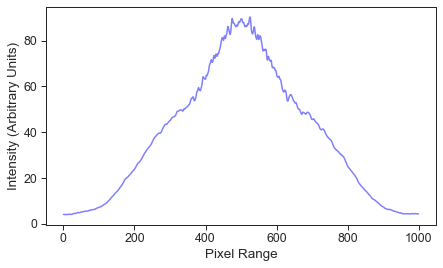

In [17]:
plt.figure(figsize=(7,4))
plt.plot(intensity_mean, label='Average Intensity Profile', color='blue', alpha=0.5, ls='-')

plt.xlabel("Pixel Range")
plt.ylabel("Intensity (Arbitrary Units)")

plt.savefig('SingleModeAverageIntensityProfile_1.pdf', dpi=400, bbox_inches='tight')

# Multi Mode Fibre Analysis

In [15]:

multi_mode_image = cv.imread('Images/MultiMode/MM_1.jpg')
# convert to RGB from BGR
multi_mode_image = cv.cvtColor(multi_mode_image, cv.COLOR_BGR2RGB)

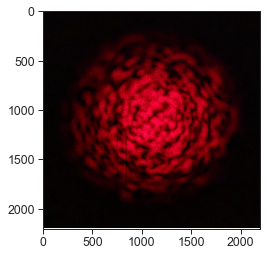

In [16]:
plt.imshow(multi_mode_image[400:2600, 950:3150])

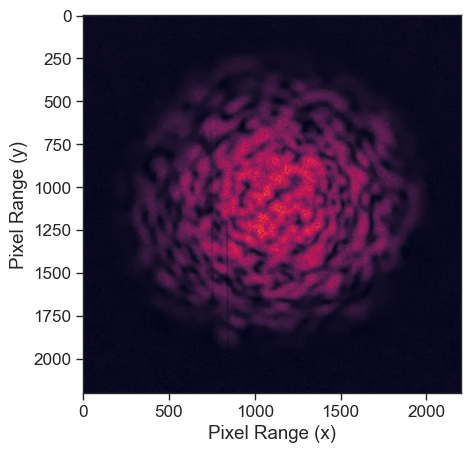

In [17]:
# get the gray scale image
multi_mode_image_gray = cv.cvtColor(multi_mode_image[400:2600, 950:3150], cv.COLOR_RGB2GRAY)

# display the gray scale image
plt.figure(figsize=(5,5), dpi=100)
plt.imshow(multi_mode_image_gray)

plt.xlabel('Pixel Range (x)')
plt.ylabel('Pixel Range (y)')

plt.savefig('MultiModeImage.pdf', dpi=400, bbox_inches='tight')

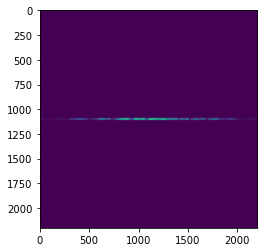

In [15]:
mask = np.zeros_like(multi_mode_image_gray)
mask[int(multi_mode_image_gray.shape[0]/2) - 10:int(multi_mode_image_gray.shape[0]/2) + 10, :] = 255

# apply the mask to the image
masked_image = cv.bitwise_and(multi_mode_image_gray, mask)

# display the masked image
plt.imshow(masked_image)

In [20]:
# keep rotating the image by 18degrees untill you get full 360 degree rotations

Theta = np.linspace(0, 360, 40)
popt_master = []
pconv_master = []
intensity_master = []
for theta in tqdm(Theta, desc='Fitting Gaussian Profiles'):
    popt, pconv, intensity = profile(multi_mode_image_gray, theta)
    popt_master.append(popt)
    pconv_master.append(pconv)
    intensity_master.append(intensity)

Fitting Gaussian Profiles: 100%|██████████| 40/40 [00:00<00:00, 80.27it/s]


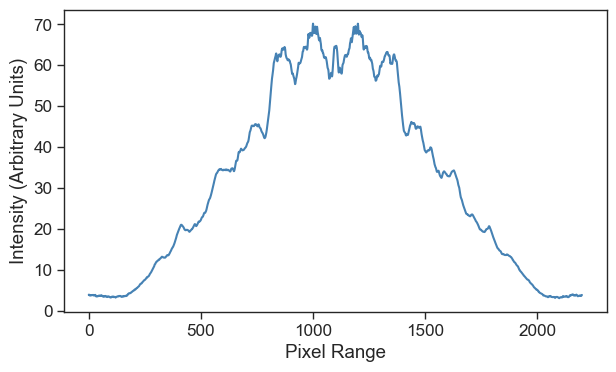

In [22]:
# setting seaborn style
sns.set_style('ticks')
sns.set_context('paper', rc={'lines.linewidth': 1.5}, font_scale=1.4)

# get the average intensity profile
intensity_master = np.array(intensity_master)
intensity_mean = intensity_master.mean(axis=0)

# plot the average intensity profile
plt.figure(figsize=(7,4), dpi=100)
plt.plot(intensity_mean, label='Average Intensity Profile', color='steelblue', ls='-')
plt.ylabel("Intensity (Arbitrary Units)")
plt.xlabel("Pixel Range")

plt.savefig('MultiModeAverageIntensityProfile.pdf', dpi=400, bbox_inches='tight')

# dual mode fibre analysis

In [29]:
dual_mode_image_1 = cv.imread('Images/DualMode/DualMode_1.jpg')
dual_mode_image_2 = cv.imread('Images/DualMode/DualMode_2.jpg')

# convert to RGB from BGR
dual_mode_image_1 = cv.cvtColor(dual_mode_image_1, cv.COLOR_BGR2RGB)
dual_mode_image_2 = cv.cvtColor(dual_mode_image_2, cv.COLOR_BGR2RGB)

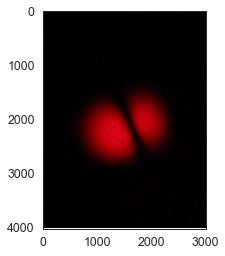

In [32]:
plt.imshow(dual_mode_image_1)

In [111]:
# get the gray scale image
DM_1_gray = cv.cvtColor(dual_mode_image_1, cv.COLOR_RGB2GRAY)
DM_2_gray = cv.cvtColor(dual_mode_image_2, cv.COLOR_RGB2GRAY)

## Dual mode Hermite-Gaussian $TEM_{10}$

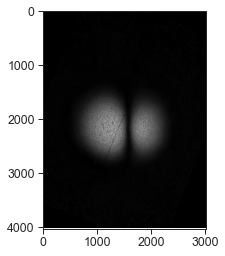

In [112]:
# rotate the image by an angle of some degrees to make the black lines parallel to the y-axis
M = cv.getRotationMatrix2D((DM_1_gray.shape[1]/2, DM_1_gray.shape[0]/2), -22, 1)
DM_1 = cv.warpAffine(DM_1_gray, M, (DM_1_gray.shape[1], DM_1_gray.shape[0]))

# display the rotated image
plt.imshow(rotated_image, cmap='gray')

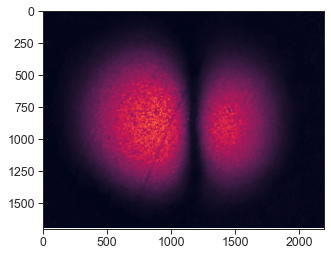

In [113]:
# cropping the image
plt.imshow(DM_1[1300:3000, 400:2600])

In [114]:
# get the cropped image
DM_1_cropped = DM_1[1300:3000, 400:2600]

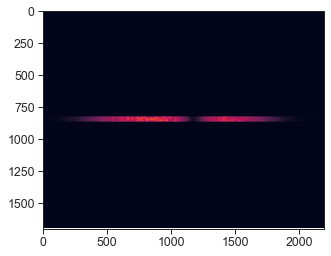

In [132]:
# create a mask
mask = np.zeros_like(DM_1_cropped)
mask[int(DM_1_cropped.shape[0]/2) - 20:int(DM_1_cropped.shape[0]/2) + 20, :] = 255

# apply the mask to the image
masked_image = cv.bitwise_and(DM_1_cropped, mask)

# display the masked image
plt.imshow(masked_image)

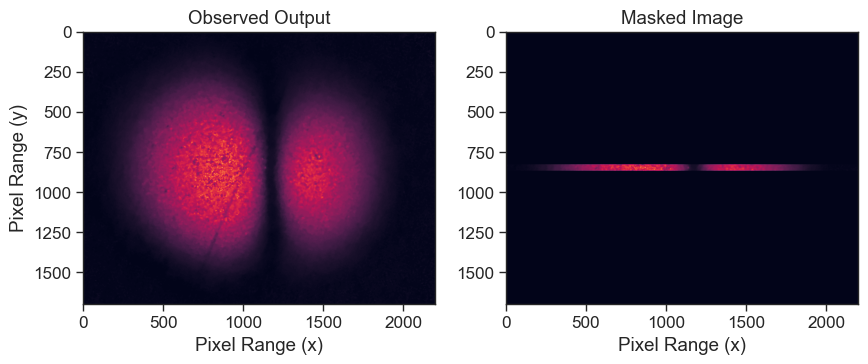

In [133]:
# create a 2 figure subplot horizontally
sns.set_style('ticks')
fig, ax = plt.subplots(1, 2, figsize=(10,5), dpi=100)

# display the original image
ax[0].imshow(DM_1_cropped)

# display the masked image
ax[1].imshow(masked_image)


# set the x and y labels
ax[0].set_xlabel('Pixel Range (x)')
ax[0].set_ylabel('Pixel Range (y)')
ax[1].set_xlabel('Pixel Range (x)')

ax[0].set_title('Observed Output')
ax[1].set_title('Masked Image')

plt.savefig('DualModeImage_TEM10.pdf', dpi=400, bbox_inches='tight')

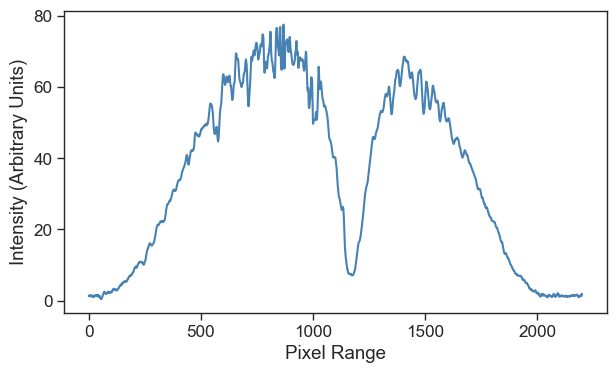

In [110]:
# get the intensity profile
DM_intensity = DM_1_cropped[int(DM_1_cropped.shape[0]/2) - 15:int(DM_1_cropped.shape[0]/2) + 15, :].mean(axis=0)

# plot the intensity profile
plt.figure(figsize=(7,4), dpi=100)
plt.plot(DM_intensity, label='Intensity Profile', color='steelblue', ls='-')
plt.ylabel("Intensity (Arbitrary Units)")
plt.xlabel("Pixel Range")

plt.savefig('DualModeIntensityProfile_TEM10.pdf', dpi=400, bbox_inches='tight')

## Dual mode Hermite-Gaussian $TEM_{00}$

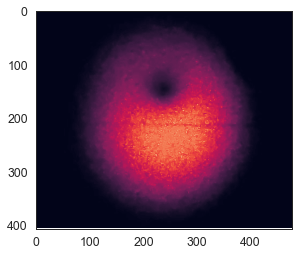

In [70]:
# rotate the image by an angle of some degrees to make the black lines parallel to the y-axis
M = cv.getRotationMatrix2D((DM_2_gray.shape[1]/2, DM_2_gray.shape[0]/2), 90, 1)
DM_2 = cv.warpAffine(DM_2_gray, M, (DM_2_gray.shape[1], DM_2_gray.shape[0]))

# display the rotated image
plt.imshow(DM_2)

Text(0, 0.5, 'Pixel Range (y)')

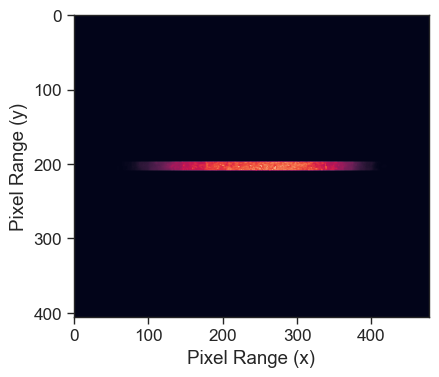

In [130]:
# create a mask
mask = np.zeros_like(DM_2)
mask[int(DM_2.shape[0]/2) - 6:int(DM_2.shape[0]/2) + 6, :] = 255

# apply the mask to the image
masked_image = cv.bitwise_and(DM_2, mask)

# display the masked image
plt.figure(figsize=(6,4), dpi=100)
plt.imshow(masked_image)
plt.xlabel('Pixel Range (x)')
plt.ylabel('Pixel Range (y)')

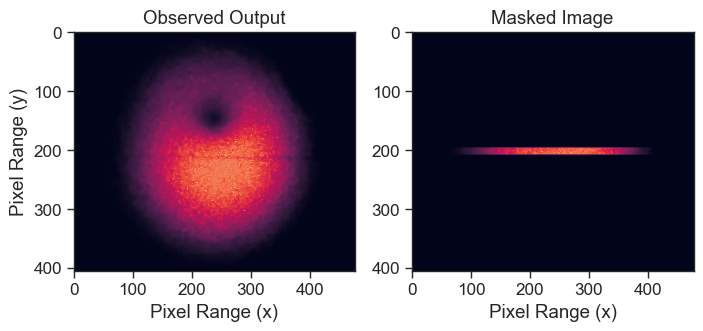

In [131]:
# create a 2 figure subplot horizontally
sns.set_style('ticks')
fig, ax = plt.subplots(1, 2, figsize=(8,5), dpi=100)

# display the original image
ax[0].imshow(DM_2)

# display the masked image
ax[1].imshow(masked_image)


# set the x and y labels
ax[0].set_xlabel('Pixel Range (x)')
ax[0].set_ylabel('Pixel Range (y)')
ax[1].set_xlabel('Pixel Range (x)')

# set the title
ax[0].set_title('Observed Output')
ax[1].set_title('Masked Image')

plt.savefig('DualModeImage_TEM00.pdf', dpi=400, bbox_inches='tight')

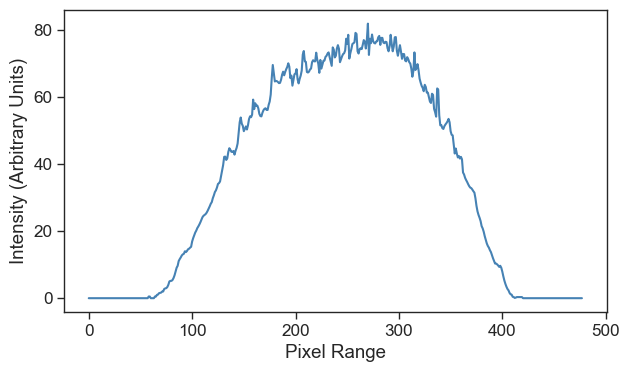

In [107]:
# get the intensity profile
DM_intensity = DM_2[int(DM_2.shape[0]/2 - 6):int(DM_2.shape[0]/2 + 6), :].mean(axis=0)

# plot the intensity profile
plt.figure(figsize=(7,4), dpi=100)
plt.plot(DM_intensity, label='Intensity Profile', color='steelblue', ls='-')
plt.ylabel("Intensity (Arbitrary Units)")
plt.xlabel("Pixel Range")

plt.savefig('DualModeIntensityProfile_TEM00.pdf', dpi=400, bbox_inches='tight')